# 混淆矩阵

通过测试集所有图像预测结果，生成多类别混淆矩阵，评估模型准确度。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置Matplotlib中文字体

In [1]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [1]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
# !rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='cmb10') # 中文字体


## 导入工具包

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import math
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 载入类别名称和ID

In [3]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['云', '仓鼠', '兔子', '兰花', '割草机', '向日葵', '城堡', '大海', '大象', '女人', '女孩', '小婴儿', '山', '巴士', '平原', '床', '恐龙', '房屋', '拖拉机', '摩天大楼', '摩托车', '时钟', '有轨电车', '杯子', '松树', '松鼠', '枫树', '柳树', '桌子', '桥', '梨', '棕榈树', '森林', '椅子', '橘子', '橡树', '比目鱼', '毛虫', '水族馆鱼类', '水濑', '沙发', '浣熊', '海狸', '海豚', '海豹', '海龟', '火箭', '火车', '灯', '熊', '牛', '狐狸', '狮子', '狼', '玫瑰', '瓶子', '甜椒', '甲虫', '电视', '电话', '男人', '男孩', '皮卡', '盘子', '碗', '箱子', '罂粟', '老虎', '老鼠', '自行车', '臭鼬', '苹果', '蘑菇', '蛇', '蜗牛', '蜘蛛', '蜜蜂', '蜥蜴', '蝴蝶', '螃蟹', '蟑螂', '蠕虫', '衣柜', '袋鼠', '豪猪', '豹', '负鼠', '郁金香', '金属罐', '键盘', '马路', '骆驼', '鲨鱼', '鲸鱼', '鳄鱼', '鳐', '鳟鱼', '黑猩猩', '鼩鼱', '龙虾']


## 载入测试集预测结果表格

In [4]:
df = pd.read_csv('测试集预测结果.csv')

In [5]:
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,马路-预测置信度,骆驼-预测置信度,鲨鱼-预测置信度,鲸鱼-预测置信度,鳄鱼-预测置信度,鳐-预测置信度,鳟鱼-预测置信度,黑猩猩-预测置信度,鼩鼱-预测置信度,龙虾-预测置信度
0,D:\dataset\c100sp\val\云\1.jpg,0,云,0,云,7,大海,32,森林,True,...,0.000068,0.000006,1.006844e-07,0.000021,1.959424e-08,3.383883e-08,5.247110e-09,1.189157e-10,8.070859e-08,7.478248e-08
1,D:\dataset\c100sp\val\云\104.jpg,0,云,0,云,14,平原,7,大海,True,...,0.005304,0.000730,1.049881e-05,0.000230,3.995917e-05,1.474082e-06,3.261636e-05,7.850291e-07,1.024485e-05,4.813013e-07
2,D:\dataset\c100sp\val\云\114.jpg,0,云,0,云,24,松树,35,橡树,True,...,0.031279,0.000470,8.852244e-06,0.000064,8.390662e-06,2.718433e-06,1.127651e-05,5.401724e-08,5.945326e-06,2.524639e-06
3,D:\dataset\c100sp\val\云\117.jpg,0,云,12,山,47,火车,32,森林,False,...,0.006685,0.000650,1.045570e-04,0.004611,2.452151e-04,6.439446e-05,1.660972e-05,4.157347e-06,9.510479e-04,5.049789e-06
4,D:\dataset\c100sp\val\云\119.jpg,0,云,0,云,7,大海,31,棕榈树,True,...,0.000078,0.000107,8.889958e-07,0.000042,1.415598e-06,4.487404e-05,8.486018e-08,2.322634e-09,2.091912e-06,1.663505e-06


## 生成混淆矩阵

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])

In [8]:
confusion_matrix_model.shape

(100, 100)

In [9]:
confusion_matrix_model

array([[84,  0,  0, ...,  0,  0,  0],
       [ 0, 54,  1, ...,  0,  0,  0],
       [ 0,  2, 77, ...,  0,  1,  1],
       ...,
       [ 0,  0,  0, ..., 99,  0,  0],
       [ 0,  1,  0, ...,  1, 66,  0],
       [ 0,  0,  0, ...,  0,  1, 97]], dtype=int64)

## 可视化混淆矩阵

In [21]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('混淆矩阵', fontsize=8)
    plt.xlabel('预测类别', fontsize=8, c='r')
    plt.ylabel('真实类别', fontsize=8, c='r')
    plt.tick_params(labelsize=8) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    # threshold = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j],
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > threshold else "black",
    #              fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [12]:
# 查看所有配色方案
# dir(plt.cm)

In [24]:
# 子豪兄精选配色方案
# Blues
# BuGn
# Reds
# Greens
# Greys
# binary
# Oranges
# Purples
# BuPu
# GnBu
# OrRd
# RdPu

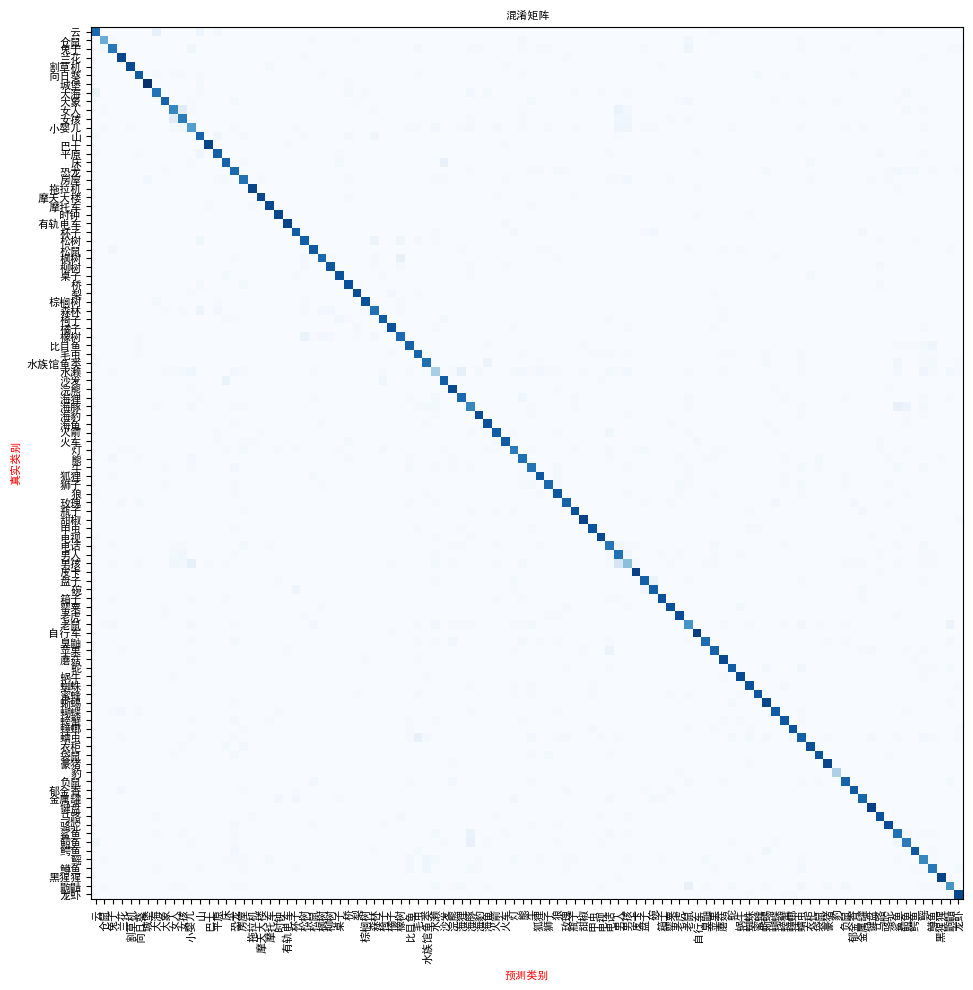

In [22]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 筛选出测试集中，真实为A类，但被误判为B类的图像

In [23]:
true_A = '男孩'
pred_B = '男人'

In [24]:
wrong_df = df[(df['标注类别名称']==true_A)&(df['top-1-预测名称']==pred_B)]

In [25]:
wrong_df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,马路-预测置信度,骆驼-预测置信度,鲨鱼-预测置信度,鲸鱼-预测置信度,鳄鱼-预测置信度,鳐-预测置信度,鳟鱼-预测置信度,黑猩猩-预测置信度,鼩鼱-预测置信度,龙虾-预测置信度
6099,D:\dataset\c100sp\val\男孩\102.jpg,61,男孩,60,男人,61,男孩,17,房屋,True,...,1.146344e-03,5.537232e-04,0.005082,3.794182e-04,0.003030,6.259878e-03,3.833753e-03,1.937372e-04,2.992276e-02,1.011551e-02
6114,D:\dataset\c100sp\val\男孩\17.jpg,61,男孩,60,男人,7,大海,58,电视,False,...,4.152547e-06,1.152631e-04,0.000008,3.133065e-04,0.000001,1.249920e-07,1.378169e-06,3.053430e-12,9.826543e-08,1.729879e-08
6115,D:\dataset\c100sp\val\男孩\18.jpeg,61,男孩,60,男人,61,男孩,10,女孩,True,...,7.754553e-06,3.633183e-06,0.000787,1.601433e-05,0.000039,2.055921e-05,2.488653e-04,1.121341e-06,4.309444e-05,2.121822e-04
6117,D:\dataset\c100sp\val\男孩\198.jpg,61,男孩,60,男人,66,罂粟,58,电视,False,...,5.632319e-05,2.518863e-04,0.001668,8.879034e-05,0.000733,2.261816e-04,1.836053e-05,3.288115e-06,6.023222e-04,1.378003e-04
6120,D:\dataset\c100sp\val\男孩\209.jpg,61,男孩,60,男人,61,男孩,8,大象,True,...,1.809112e-04,9.879854e-04,0.018030,2.312080e-03,0.000892,1.168721e-03,4.503707e-04,2.484394e-06,4.686042e-04,2.891496e-04
6122,D:\dataset\c100sp\val\男孩\227.jpg,61,男孩,60,男人,61,男孩,9,女人,True,...,1.578163e-04,4.646557e-05,0.001055,8.178634e-06,0.000575,1.264955e-03,1.320037e-03,2.389592e-05,6.248658e-04,6.099803e-03
6129,D:\dataset\c100sp\val\男孩\266.jpg,61,男孩,60,男人,61,男孩,11,小婴儿,True,...,3.560972e-07,3.362418e-05,0.000520,7.949919e-05,0.000036,7.460459e-06,1.188453e-05,6.265657e-07,7.734058e-05,1.894987e-05
6132,D:\dataset\c100sp\val\男孩\271.jpeg,61,男孩,60,男人,23,杯子,95,鳐,False,...,1.407557e-06,2.401707e-06,0.000078,3.125589e-06,0.000005,4.946392e-03,1.229964e-05,3.520520e-07,6.357762e-04,1.886205e-05
6144,D:\dataset\c100sp\val\男孩\32.jpeg,61,男孩,60,男人,61,男孩,11,小婴儿,True,...,1.203226e-06,5.001726e-07,0.000167,1.020840e-06,0.000044,1.075299e-05,3.464334e-05,7.157946e-06,3.523337e-04,1.135416e-05
6149,D:\dataset\c100sp\val\男孩\349.png,61,男孩,60,男人,61,男孩,59,电话,True,...,1.846645e-07,5.432220e-06,0.000030,9.586352e-07,0.000002,4.150644e-05,9.666314e-07,4.970866e-06,2.605173e-04,1.415493e-05


## 可视化上表中所有被误判的图像

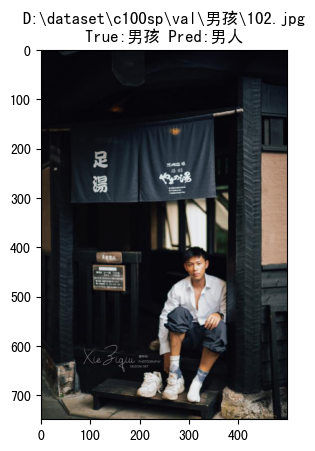

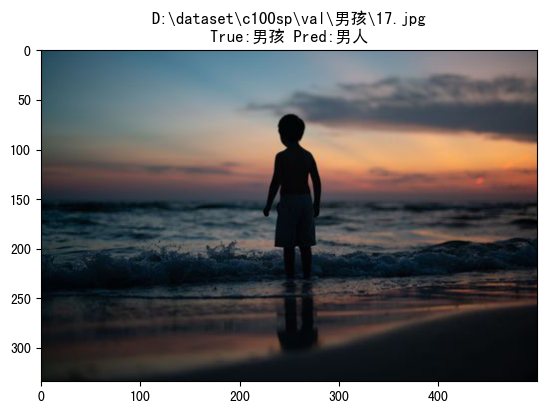

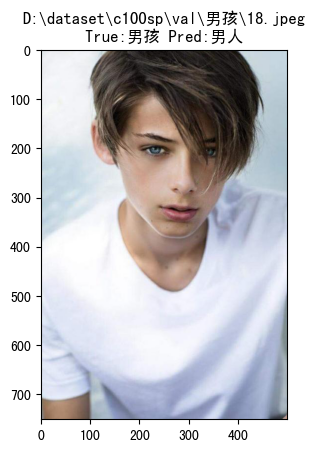

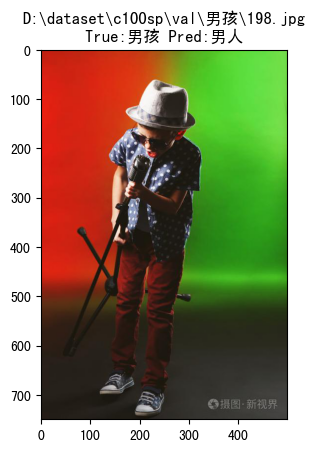

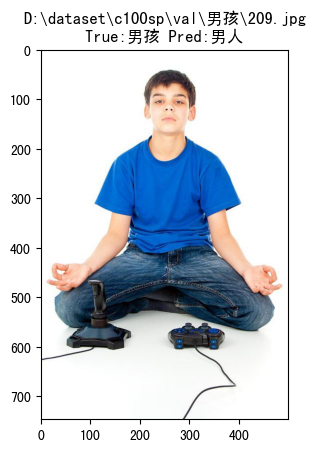

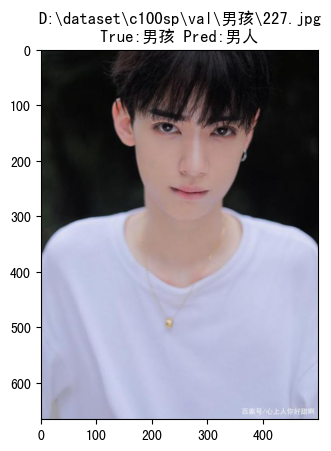

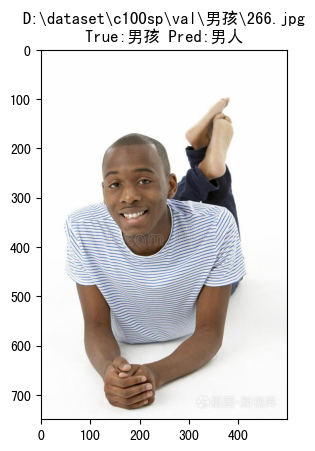

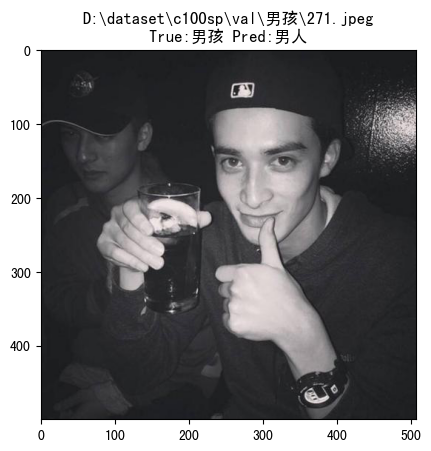

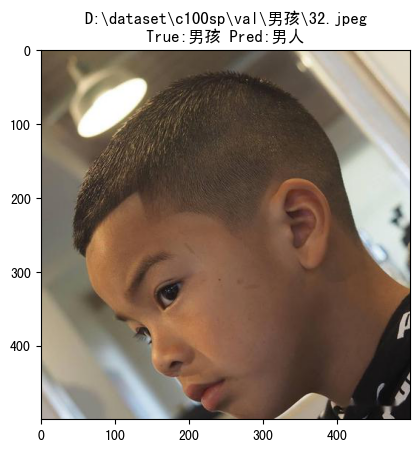

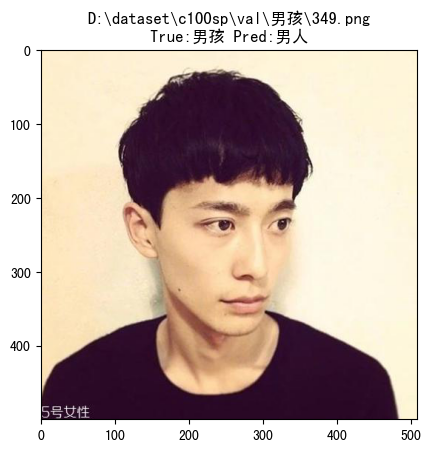

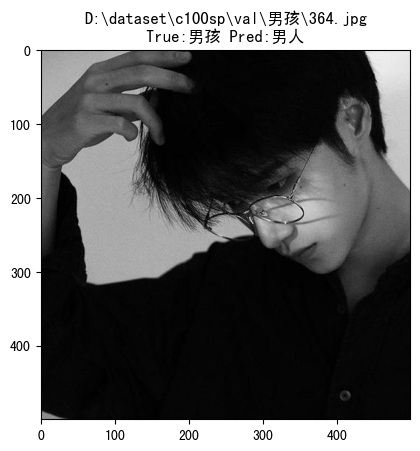

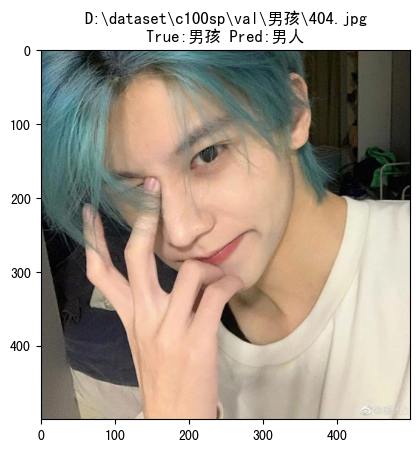

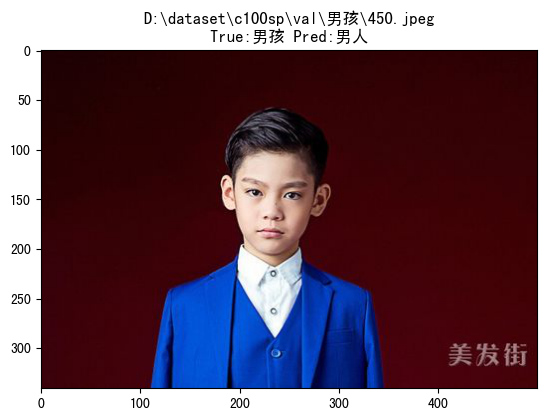

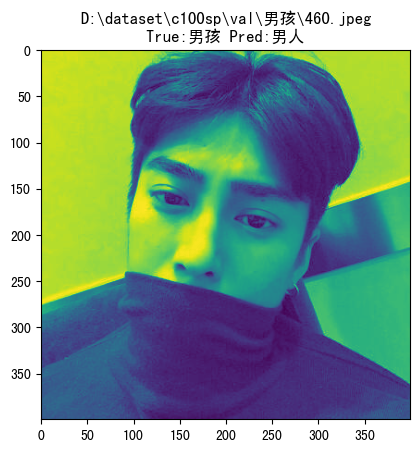

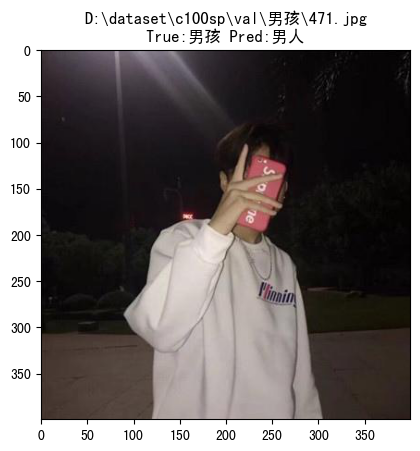

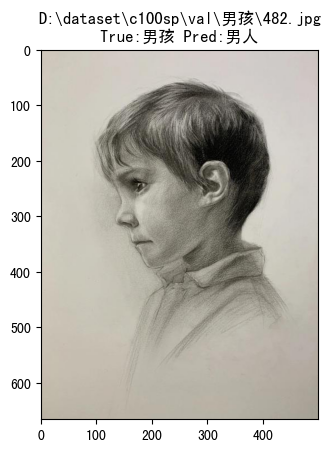

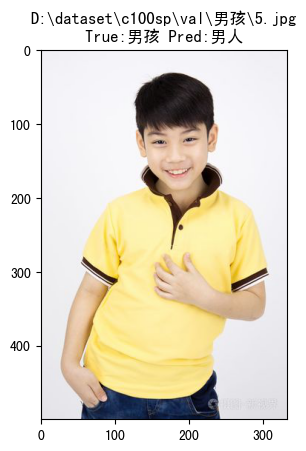

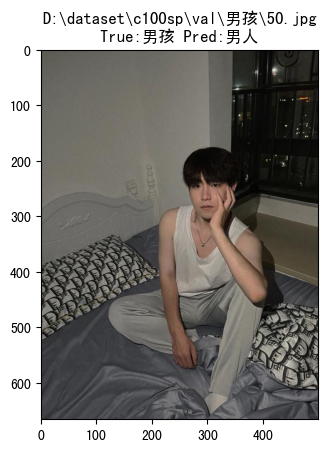

In [29]:
import PIL.Image as Image
for idx, row in wrong_df.iterrows():
    img_path = row['图像路径']
    # img_bgr = cv2.imread(img_path)
    # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = Image.open(img_path)
    plt.imshow(img_rgb)
    title_str = img_path + '\nTrue:' + row['标注类别名称'] + ' Pred:' + row['top-1-预测名称']
    plt.title(title_str)
    plt.show()